# PageRank
#### Author : Alex Fender

In this notebook, we will show how to use multi-GPU features in cuGraph to compute the PageRank of each user in Twitter's dataset.

Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. If you think you have found a bug or an error, please file an issue in [cuGraph](https://github.com/rapidsai/cugraph/issues)

This notebook was run on 2 NVIDIA Tesla V100 GPUs (connected with nvlink) using RAPIDS 0.9.0 and CUDA 10.0. 

## Introduction
Pagerank is measure of the relative importance of a vertex based on the relative importance of its neighbors.  PageRank was invented by Google Inc. and is (was) used to rank it's search results. PageRank uses the connectivity information of a graph to rank the importance of each vertex. See [Wikipedia](https://en.wikipedia.org/wiki/PageRank) for more details on the algorithm.

CuGraph's multi-GPU features leverage Dask. RAPIDS has other projects based Dask such as dask-cudf and dask-cuda. They will also be used in this example. Check out [RAPIDS.ai](https://rapids.ai/) to learn more about these technologies.

To compute the Pagerank scores for a graph in cuGraph we use:<br>

```python
cugraph.dask.pagerank.pagerank(edge_list, alpha=0.85, max_iter=30)
```
Parameters

*  *edge_list* : `dask_cudf.DataFrame`<br>
Contain the connectivity information as an edge list. Source 'src' and destination 'dst' columns must be of type 'int32'. Edge weights are not used for this algorithm. Indices must be in the range [0, V-1], where V is the global number of vertices. The input edge list should be provided in dask-cudf dataframe with one partition per GPU.
*  *alpha* : `float`<br>
The damping factor alpha represents the probability to follow an outgoing edge, standard value is 0.85. Thus, 1.0-alpha is the probability to “teleport” to a random vertex. Alpha should be greater than 0.0 and strictly lower than 1.0.
* *max_iter* : `int`<br>
The maximum number of iterations before an answer is returned. If this value is lower or equal to 0 cuGraph will use the default value, which is 30.<br>

Returns

* *PageRank* : `dask_cudf.DataFrame`<br>
Dask GPU DataFrame containing two columns of size V: the vertex identifiers and the corresponding PageRank values.

## Data
We will be analyzing 41.7 million user profiles and 1.47 billion social relations from the Twitter dataset.  The file is 26GB and was collected in :<br>
*What is Twitter, a social network or a news media? Haewoon Kwak, Changhyun Lee, Hosung Park, and Sue Moon. 2010.*<br> 

Please refer to the readme to obtain this dataset.

## Multi-GPU PageRank with cuGraph
### Basic setup

In [ ]:
# Let's check out our hardware setup
!nvidia-smi

# GPUs should be connected with NVlink
!nvidia-smi nvlink --status

# For best performance, we can limit the number of available devices
# For this dataset to 2 Tesla V100(32GB) is ideal
#!export CUDA_VISIBLE_DEVICES=0,1 

In [ ]:
# Import needed libraries
import time
from dask.distributed import Client, wait
import dask_cudf
from dask_cuda import LocalCUDACluster
import cugraph.dask.pagerank as dcg

### Setup multi-GPU and dask

Before we get started, we need to setup a Dask local cluster of workers to execute our work and a client to coordinate and schedule work for that cluster. As we see below, we can inititate a `cluster` and `client` using only few lines of code.

In [ ]:
cluster = LocalCUDACluster(threads_per_worker=1)
client = Client(cluster)

### Read the data from disk
cuGraph depends on dask-cudf for data loading and the initial DataFrame creation. The CSV data file contains an edge list, which represents the connection of a vertex to another. The source to destination pairs is what is known as Coordinate Format (COO). In this test case, the data is just two columns. 

In [ ]:
# File path, assuming current directory
input_data_path = r"/cugraph_data/benchmark/twitter/twitter-2010.csv"

# Helper function to set the reader chunck size to automatically get one partition per GPU  
chunksize = dcg.get_chunksize(input_data_path)

# Start timer
t_start = time.time()

# Multi-GPU CSV reader
e_list = dask_cudf.read_csv(input_data_path, chunksize = chunksize, delimiter=' ', names=['src', 'dst'], dtype=['int32', 'int32'])

# Wait for the lazy reader
tmp = wait(client.compute(e_list.to_delayed()))

# Print time
print(time.time()-t_start, "s")

### Call the Multi-GPU PageRank algorithm


In [ ]:
# Start timer
t_start = time.time()

# Get the pagerank scores
pr_ddf = dcg.pagerank(e_list, max_iter=20)

# Print time
print(time.time()-t_start, "s")

It was that easy! PageRank should only take a few seconds to run on this 26GB input with 2 GPUs.<br>
Check out how it compares to published results in the [Annex](#annex_cell).

### Further analysis on the Pagernak result

We can now identify the most influant users in the network.<br>
Notice that the pagerank result can fit in one GPU, so we can gather it in a regular `cudf.DataFrame`. We will then sort by pagernak value and print the *Top 3*.

In [ ]:
# Start timer
t_start = time.time()

# Dask Data Frame to regular cuDF Data Frame 
pr_df = pr_ddf.compute()

# Sort, descending order
pr_sorted_df = pr_df.sort_values('pagerank',ascending=False)

# Print time
print(time.time()-t_start, "s")

# Print the Top 3
print(pr_sorted_df.head(3))

We can now use the [map](https://s3.us-east-2.amazonaws.com/rapidsai-data/cugraph/benchmark/twitter-2010-ids.csv.gz) to convert Vertex ID into to Twitter's numeric ID. The user name can also be retreived using [TwitterID](https://tweeterid.com/).<br>
The table below shows more information on our *Top 3*. Notice that this ranking is much much better at capturing   network influance compared the number of followers for instance. Further analysis of this dataset can be found [here](https://doi.org/10.1145/1772690.1772751).

| Vertex ID	| Twitter ID	| User name	| Description |
| --------- |  ---------   | --------   |   ----------  |
| 21513299	| 813286	| barackobama	| US President (2009-2017) |
| 23933989	| 14224719	| 10DowningStreet | UK Prime Minister office |
| 23933986	| 15131310	| WholeFoods	| Food store from Austin |



### Close the multi-GPU environment

In [ ]:
client.close()
cluster.close()

## Annex
<a id='annex_cell'></a>
An experiment on this same dataset comparing various solutions was published in *GraphX: Graph Processing in a Distributed Dataflow Framework,OSDI, 2014*. They used 16 m2.4xlarge worker nodes on Amazon EC2. There was a total of 128 CPU cores and 1TB of memory in this 2014 setup.

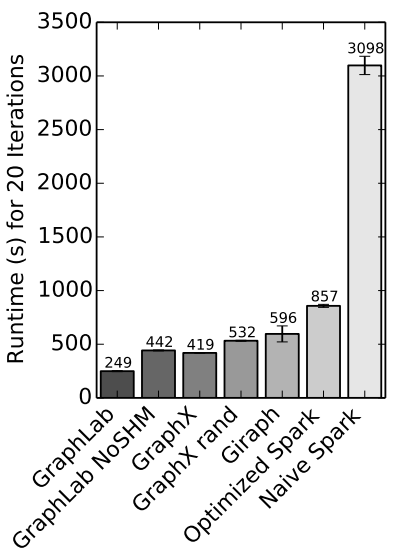

___
Copyright (c) 2019, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License");  you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
___